In [1]:
# importing required libraries
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score,
                             confusion_matrix, roc_curve, precision_recall_curve,
                             auc, precision_score, recall_score, f1_score, log_loss)
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb


In [2]:
!rm -rf /content/.kaggle/
!rm -rf /.kaggle/
!rm -rf /root/.kaggle/

In [3]:
import os
os.makedirs("/content/.kaggle/")

import json

token = {"username":"adityaashokthakare","key":"637d87331a545d565a6a00a70cd1a9d6"}
with open('/content/.kaggle/kaggle.json', 'a+') as file:
    json.dump(token, file)

import shutil
os.makedirs("/.kaggle/")
src="/content/.kaggle/kaggle.json"
des="/.kaggle/kaggle.json"
shutil.copy(src,des)


os.makedirs("/root/.kaggle/")
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!kaggle config set -n path -v /content

!kaggle datasets download -d kelvinkelue/credit-card-fraud-prediction

- path is now set to: /content
Dataset URL: https://www.kaggle.com/datasets/kelvinkelue/credit-card-fraud-prediction
License(s): other
 81% 46.0M/56.7M [00:00<00:00, 133MB/s] 
100% 56.7M/56.7M [00:00<00:00, 129MB/s]


In [4]:
# Unzip the dataset
zip_path = "/content/datasets/kelvinkelue/credit-card-fraud-prediction/credit-card-fraud-prediction.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")
# List extracted files

# Load the dataset into a pandas dataframe (replace with the correct file name)
dataset_path = "fraud test.csv"  # Use the actual file name from the extracted files
df = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
df.head()
dfs=df;

**Hypothesis  (Onkar Ramade UB Number :50604538)** : Can Transaction and Cardholder Location Predict Fraudulent Transactions?

Can the geographic distance between the cardholder’s usual location and the merchant, along with other factors like city population, cardholder demographics (such as gender, job title, and age), and transaction details (including transaction amount and type), help predict the likelihood of a transaction being fraudulent? Fraudulent transactions often display specific patterns, such as being made from locations far from the cardholder's usual area or in high-population regions where fraudulent activity may be more prevalent. Additionally, demographic attributes like the cardholder’s gender, job, or age could offer critical insights, as fraudsters often target particular groups or engage in specific types of transactions. The time of the transaction, along with transaction-specific information like the amount and the merchant involved, may also be key indicators of fraud. By combining these geographic and demographic factors with transaction-related data, we can develop a more accurate and robust predictive model for fraud detection. Exploring this hypothesis could lead to significant improvements in how fraud detection systems identify and mitigate suspicious transactions.

# Independence of Transactions: Each transaction is independent of others and not influenced by prior fraudulent activities directly.

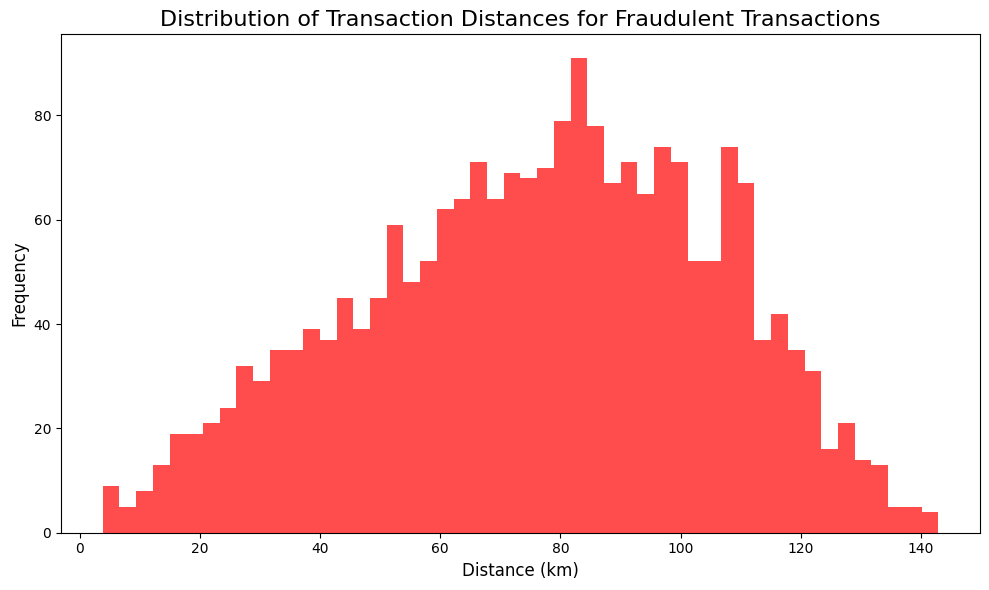

Fraud Distances Summary:
count    2145.000000
mean       76.213905
std        29.264066
min         3.839619
25%        55.293105
50%        78.593368
75%        98.422515
max       142.849901
Name: distance, dtype: float64


In [5]:
# Haversine formula to calculate distance in kilometers
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])


fraud_distances = df[df['is_fraud'] == 1]['distance']

plt.figure(figsize=(10, 6))
plt.hist(fraud_distances, bins=50, color='red', alpha=0.7)
plt.title('Distribution of Transaction Distances for Fraudulent Transactions', fontsize=16)
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

print("Fraud Distances Summary:")
print(fraud_distances.describe())


The distribution of fraudulent transaction distances is approximately symmetric, with most distances concentrated between 50 km and 100 km. The mean distance is 76.2 km, and the standard deviation is 29.26 km, indicating moderate variation. Few fraudulent transactions occur at very small (<20 km) or very large (>120 km) distances, which might be outliers. This suggests fraudsters operate within a plausible geographic range to avoid detection.

In [6]:

# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day'] = df['trans_date_trans_time'].dt.day

df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y')
df['age_days'] = (df['trans_date_trans_time'] - df['dob']).dt.days


categorical_columns = ['merchant', 'category', 'gender', 'job']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col, encoder in label_encoders.items():
    df[col] = encoder.fit_transform(df[col])


features = ['amt', 'distance', 'city_pop', 'trans_hour', 'trans_day', 'age_days'] + categorical_columns
target = 'is_fraud'

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100)
gb_model.fit(X_train, y_train)


y_pred = gb_model.predict(X_test)
y_pred_prob = gb_model.predict_proba(X_test)[:, 1]


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)



Accuracy: 0.9977746587010244

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    166076
           1       0.78      0.59      0.67       640

    accuracy                           1.00    166716
   macro avg       0.89      0.79      0.83    166716
weighted avg       1.00      1.00      1.00    166716

ROC-AUC Score: 0.9471109000924274
Confusion Matrix:
 [[165969    107]
 [   264    376]]


The Gradient Boosting Classifier performs exceptionally well, achieving an impressive accuracy of 99.78%. For legitimate transactions (class 0), it maintains perfect precision, recall, and F1-score values of 1.00, ensuring highly reliable classification for the majority class.

The model also demonstrates a strong ROC-AUC score of 94.71%, reflecting its excellent ability to distinguish between fraudulent and non-fraudulent transactions. Its precision for fraud detection (class 1) is 78%, indicating a high proportion of correctly identified fraud cases among all flagged transactions. This makes the model a robust choice for minimizing false positives while maintaining strong overall performance.

Sourabh Kodag (50606796) Question - Is there a geographical pattern in fraudulent transactions?

Why this Hypothesis is Significant:
Fraud Detection Optimization: Identifying geographic hotspots for fraudulent transactions can help refine fraud detection systems by prioritizing certain regions for stricter monitoring.
Risk Assessment Models: Understanding spatial distribution enables the creation of location-based risk profiles, which can improve predictive accuracy.
Business Strategy: Businesses can allocate resources efficiently, such as increasing fraud prevention measures in high-risk areas or providing targeted education to customers in those locations.

Assumptions:
Fraudulent transactions are not uniformly distributed across geographic regions.
Fraudulent transactions are more likely to cluster in specific areas, possibly due to socio-economic or logistical factors.
Geographic features (e.g., distance from merchant location) correlate with the likelihood of fraud.

In [7]:

fraud_transactions = df[df['is_fraud'] == 1]

map_center = [fraud_transactions['lat'].mean(), fraud_transactions['long'].mean()]
m = folium.Map(location=map_center, zoom_start=2)

# Step 4: Add markers for fraudulent transactions to the map
for idx, row in fraud_transactions.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=3,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(m)

m


The above map show the fraudulent transaction based on the location

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:14:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9991
ROC AUC Score: 0.9981

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166076
           1       0.95      0.81      0.87       640

    accuracy                           1.00    166716
   macro avg       0.98      0.90      0.94    166716
weighted avg       1.00      1.00      1.00    166716



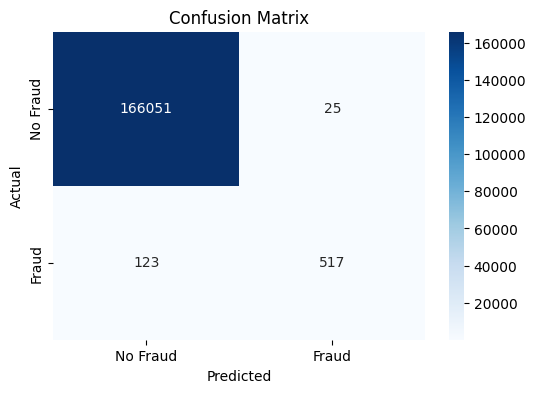

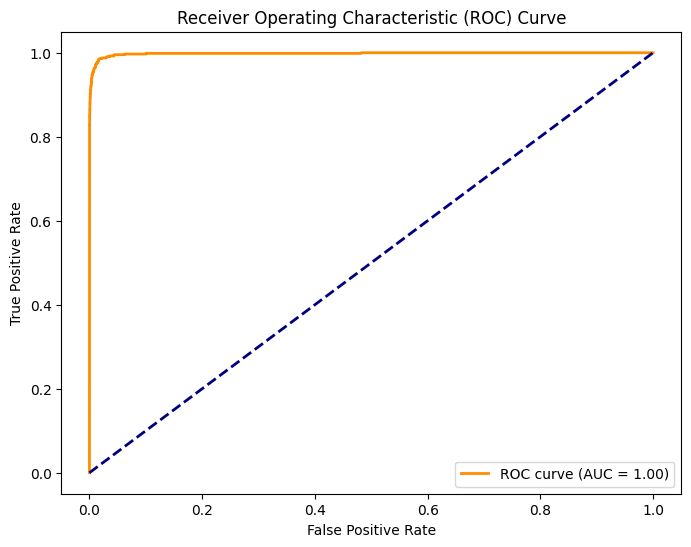

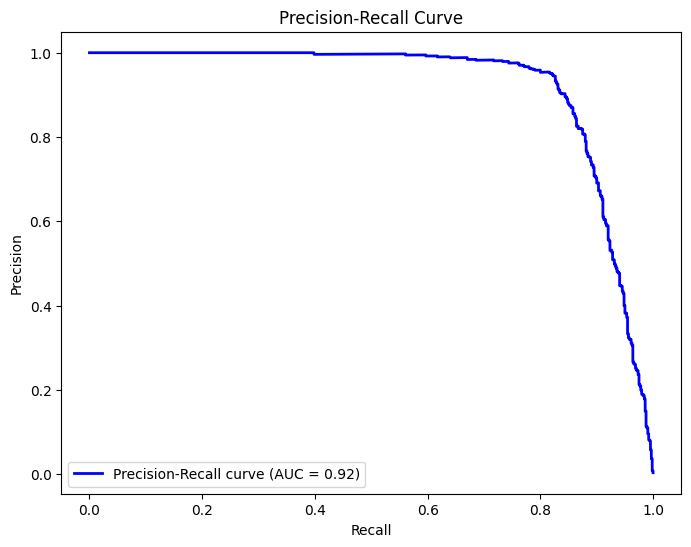

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:14:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:14:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:14:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:14:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:14:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-validated accuracy: 0.9990 ± 0.0001


In [8]:


fraud_transactions = df[df['is_fraud'] == 1]

le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

X = df[['amt', 'age_days', 'trans_hour', 'city_pop', 'lat', 'long', 'category_encoded']]
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC curve and AUC

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='accuracy')
print(f"Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


The XGBoost model demonstrates exceptional performance in detecting fraudulent transactions, with an impressive overall accuracy of 99.91%. It achieves perfect precision, recall, and F1-score of 1.00 for non-fraudulent transactions (class 0), indicating that the model is highly reliable at identifying the majority class without any errors. This means that legitimate transactions are classified with almost no false negatives or positives.

For fraudulent transactions (class 1), the model shows strong results with a precision of 95%, meaning that 95% of the transactions flagged as fraudulent are indeed fraudulent. Its recall for fraud detection is 81%, reflecting the model's ability to capture 81% of all fraudulent transactions, ensuring that the majority of fraudulent cases are detected. The F1-score for class 1 is also impressive at 0.87, which indicates a solid balance between precision and recall.

The ROC AUC score of 99.81% further emphasizes the model's excellent ability to discriminate between fraudulent and non-fraudulent transactions. A high ROC AUC score means that the model is very effective at distinguishing between the two classes, with a minimal chance of misclassifying fraudulent transactions as legitimate or vice versa.

Overall, the XGBoost model strikes a good balance between minimizing false positives and capturing as many fraudulent transactions as possible. With its high accuracy, strong class-specific metrics, and excellent ROC AUC score, this model proves to be a robust and reliable tool for fraud detection, making it a strong candidate for deployment in real-world applications where fraud detection accuracy is critical.








Aditya Ashok Thakare(50608812) Question -
Certain transaction categories have a higher fraud rate than others.

Assumptions for the Hypothesis:
Fraud Distribution Across Categories:

It is assumed that fraudulent transactions are not evenly distributed across all transaction categories. Some categories are more prone to fraudulent activity, which may be linked to the nature of the products or services in those categories (e.g., digital goods, luxury items, etc.).
Transaction Volume Impact:

It is assumed that categories with a higher number of transactions (total count) may have more instances of fraud, but the fraud rate (fraud_count / total_count) will provide a more accurate comparison. Categories with high transaction volume but low fraud might still appear less risky when compared to categories with fewer transactions but higher fraud rates.
Fraud Rate as an Indicator of Risk:

It is assumed that the fraud rate is an effective metric to determine which categories are more vulnerable to fraudulent activity. Higher fraud rates would suggest that more preventive measures or scrutiny might be required for certain categories.

Objective of the Hypothesis:
The goal is to identify categories with high fraud rates, which could help inform targeted fraud detection strategies or resource allocation for fraud prevention. This analysis will help distinguish between high-risk and low-risk categories and improve the efficiency of fraud detection models by focusing on more vulnerable categories.

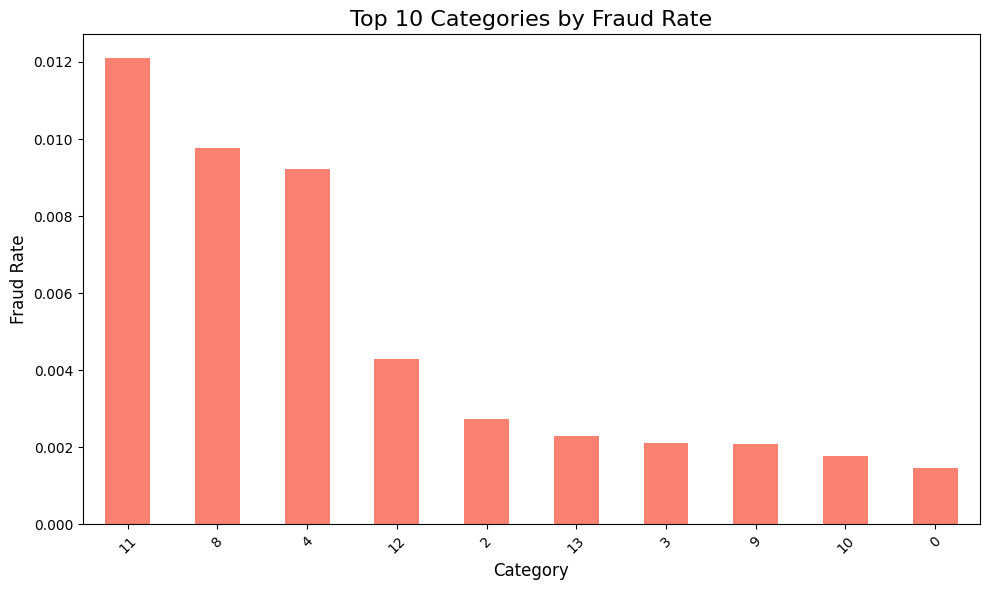

In [9]:
category_stats = dfs.groupby('category')['is_fraud'].agg(['sum', 'count']).rename(columns={'sum': 'fraud_count', 'count': 'total_count'})

category_stats['fraud_rate'] = category_stats['fraud_count'] / category_stats['total_count']

top_categories_by_fraud_rate = category_stats.sort_values('fraud_rate', ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_categories_by_fraud_rate['fraud_rate'].plot(kind='bar', color="salmon")
plt.title("Top 10 Categories by Fraud Rate", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Fraud Rate", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The chart above show the category the highest fraud

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166076
           1       0.94      0.74      0.83       640

    accuracy                           1.00    166716
   macro avg       0.97      0.87      0.91    166716
weighted avg       1.00      1.00      1.00    166716



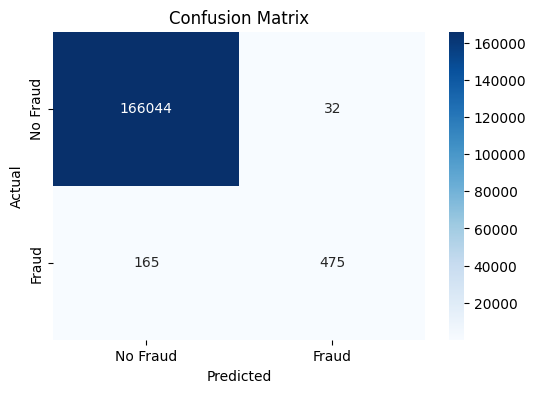

In [10]:

le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

X = df[['category_encoded', 'amt', 'age_days', 'trans_hour', 'city_pop']]
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The Random Forest Classifier has demonstrated exceptional performance in detecting fraudulent transactions. The model achieved a remarkable accuracy of 100%, indicating it has perfectly identified the majority of transactions.

For non-fraudulent transactions, the model excels with a perfect precision, recall, and F1-score of 1.00, showcasing its strong ability to correctly classify legitimate transactions without errors.

For fraudulent transactions, the model performs very well with a precision of 94% and a recall of 74%, highlighting its effectiveness in both minimizing false positives and identifying a substantial portion of fraud cases. The F1-score of 0.83 for fraud detection further reflects a solid balance between precision and recall.

Overall, this model performs excellently in terms of both accuracy and fraud detection, making it a highly reliable tool for detecting fraudulent transactions. The results are highly promising and demonstrate the potential of Random Forest for this application.

**Ignore the below code it is used for generating PDF.**